In [73]:
import pandas as pd
import os

# Generate Unlabeled Data

In [75]:
datadir = '../../data'
wikidf = []
newsdf = []

for file in os.listdir(datadir):
    if 'wiki' in file: 
        df = pd.read_csv(datadir + '/' + file)[['news_id', 'title', 'wiki', 'entity']]
        
        # add date column
        date = '-'.join(file.split('-')[0:3])
        df['date'] = date
        
        # remove duplicates
        df.drop_duplicates(['title', 'news_id', 'date'])
        
        # set index
        df = df.reset_index()
        df.rename(columns={'index': 'wiki_id'}, inplace=True)
        wikidf.append(df)
    elif 'news' in file:
        df = pd.read_csv(datadir + '/' + file)[['news_id', 'news']]
        date = '-'.join(file.split('-')[0:3])
        df['date'] = date
        newsdf.append(df)
        
data = pd.concat(wikidf).merge(pd.concat(newsdf))
data = data[['news_id', 'wiki_id', 'date', 'news', 'entity', 'title', 'wiki']]
data = data.sort_values(['date', 'news_id', 'wiki_id'])
data.to_csv('unlabeled_data.csv', index=False)

# Evaluate Labeled Data

(373)

In [124]:
labeled_data = pd.read_csv('labeled_data.csv')
labeled_data = labeled_data.dropna()

In [125]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

from difflib import SequenceMatcher

def sim_sm(x):
    return SequenceMatcher(None, x[0], x[1]).ratio()

def lev_sim(a, b):
    return distance(None, a, b).ratio()

In [126]:
labeled_data['wiki'] = labeled_data['wiki'].str.lower().str.split()
labeled_data['news'] = labeled_data['news'].str.lower().str.split()
labeled_data['wiki'] = labeled_data['wiki'].apply(lambda x: ' '.join([item for item in x if item not in stop_words]))
labeled_data['news'] = labeled_data['news'].apply(lambda x: ' '.join([item for item in x if item not in stop_words]))

In [79]:
from scipy import stats


In [80]:
import math
import re
from collections import Counter

WORD = re.compile(r"\w+")


def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)


def cos_pipeline(x):
    vector1 = text_to_vector(x[0])
    vector2 = text_to_vector(x[1])

    return get_cosine(vector1, vector2)

def sp_pipeline(x):
    vector1 = text_to_vector(x[0])
    vector2 = text_to_vector(x[1])
    print(vector1)
    print(stats.spearmanr(vector1, vector2))

In [18]:
# !python -m spacy download en_core_web_lg

In [19]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

def render_spacy(text):
    doc = nlp(text)
    return displacy.render(doc, style="ent", jupyter=False)


In [145]:
from pathlib import Path


In [150]:
doc = nlp(documentA)
print(doc.ents)
svg = displacy.render(doc, style="ent", jupyter=False)
output_path = Path("test.svg")
output_path.open("w", encoding="utf-8").write(svg)


(Yellen Tries To Walk Back Rate Hike Warning, Apple, Treasury, Janet Yellen, Fed)


1736

In [151]:
svg

'<div class="entities" style="line-height: 2.5; direction: ltr">Market Rally Split Again; \n<mark class="entity" style="background: #aa9cfc; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    Yellen Tries To Walk Back Rate Hike Warning\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PERSON</span>\n</mark>\n - The market rally is split again as \n<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    Apple\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">ORG</span>\n</mark>\n led a tech sell-off. \n<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    Treasury\n    <span style="font-size: 0.8em; font-weight: bold;

In [82]:
def news2entities(news):
    """ Use space to convert a news description into lists of entities and labels """

    nlp = spacy.load("en_core_web_sm")
    doc = nlp(news)

    entities = []
    for ent in doc.ents:
        if (ent.label_ in ['PERSON', 'FAC', 'ORG', 'NORP', 'PRODUCT']) and (ent.text not in entities):
            text = ent.text
            if (ent.label_ == 'ORG'):
                text += ' (organization)'
            entities.append(text)

    return entities


In [63]:
def wiki_query(query, timeout=300):
    """ Given a search query, returns suggested Wikipedia pages

    Args:
        query: `str` word or phrase to search for
        timeout: `int` timeout after default 300 seconds

    Returns:
        object: `JSON` formatted data
    """
    S = requests.Session()
    URL = "https://en.wikipedia.org/w/api.php"

    PARAMS = {'action': 'query',
              'format': 'json',
              'list': 'search',
              'srsearch': query}

    try:
        R = S.get(url=URL, params=PARAMS, timeout=timeout)
        return R.json()

    except requests.ConnectionError as e:
        logger.error("Connection Error. Make sure you are connected to Internet.")
        raise Exception()

    except urllib3.exceptions.ReadTimeoutError as e:
        logger.warning("Timeout Error after %i seconds", timeout)
    except requests.exceptions.ReadTimeout as e:
        logger.warning("Timeout Error after %i seconds", timeout)
    except timeout as e:
        logger.warning("Timeout Error after %i seconds", timeout)

    except requests.RequestException as e:
        logger.error("General Error: %s", str(e))
        raise Exception()


In [64]:
import requests
documentA = 'Texas Legislature close to adding new restrictions to voting process -   Texas Republican lawmakers moved closer Saturday to imposing a slew of new restrictions on voting, as key House and Senate members struck a deal on legislation that would make mail-in voting more difficult and prohibit the after-hours and drive-through option‚Ä¶'
entities = news2entities(documentA)
for ent in entities:
    print(f'QUERY: {ent}')
    articledata = wiki_query(ent)
    search_results = articledata['query']['search']
    for i in [0, 1, 2]:
        print(search_results[i]['title'])

QUERY: Texas Legislature (organization)
Governor of Texas
Abortion in Texas
LGBT rights in Texas
QUERY: Republican
Republican
Republican Party (United States)
Irish Republican Army
QUERY: House (organization)
United States House Rules Subcommittee on Rules and the Organization of the House
Homemaking
Intergovernmental organization
QUERY: Senate (organization)
Senate Democratic Caucus
Senate of the Philippines
Senate


In [68]:
# def tdidf(x):
#     vectorizer = TfidfVectorizer()
#     vectors = vectorizer.fit_transform([x[0], x[1]])
#     feature_names = vectorizer.get_feature_names()
#     dense = vectors.todense()
#     denselist = dense.tolist()
#     df = pd.DataFrame(denselist, columns=feature_names)

#     df = df.transpose()
#     df['product'] = df[0] * df[1]
#     return df.loc[df['product'] != 0].sort_values(1, ascending=False)

In [83]:
# labeled_data['tdidf'] = labeled_data[['wiki', 'news']].apply(tdidf, axis=1)

<AxesSubplot:>

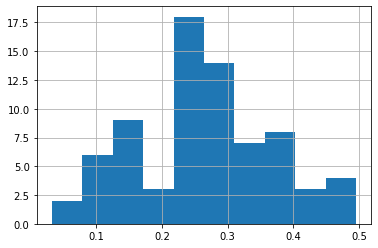

In [84]:
labeled_data['cos_sim'] = labeled_data[['wiki', 'news']].apply(cos_pipeline, axis=1)
labeled_data['cos_sim'].hist()

<AxesSubplot:>

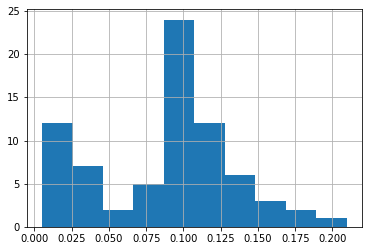

In [129]:
labeled_data['sm_sim'] = labeled_data[['wiki', 'news']].apply(sim_sm, axis=1)
labeled_data['sm_sim'].hist()

In [160]:
def render_text(text, entities):
    entity_locs = []
    for ent in entities:
        start = text.find(ent)
        end = start + len(ent)
        entity_locs.append({'start': start, 'end': end, 'label': 'custom'})

    colors = {"custom": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
    options = {"ents": ["custom"], "colors": colors}

    doc = [{"text": text,
            "ents": [{"start": 4, "end": 10, "label": "custom"}],
            "title": None}]
    return displacy.render(doc, style="ent", jupyter=False, manual=True)


def apply_render(df):

    temp_dict = df.groupby(['news'])['entity'].apply(list).to_dict()
    return [render_text(k, temp_dict[k]) for k in temp_dict]


len(apply_render(labeled_data))
# df['news'].nunique()

30

In [173]:
def render_text(text, entities):
    entity_locs = []
    for ent in entities:
        if '(organization)' in ent:
            ent.replace('(organization)', '')

        start = text.find(ent)
        end = start + len(ent)
        entity_locs.append({'start': start, 'end': end, 'label': ''})

    colors = {"": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
    options = {"ents": [""], "colors": colors}

    doc = [{"text": text,
            "ents": entity_locs,
            "title": None}]
    displacy.render(doc, style="ent", manual=True, options=options)

text = """Naomi Osaka faces French Open expulsion after media boycott - Japanese tennis player fined $15,000 for skipping the news conference after her first-round victory"""
render_text(text, ['Naomi Osaka'])

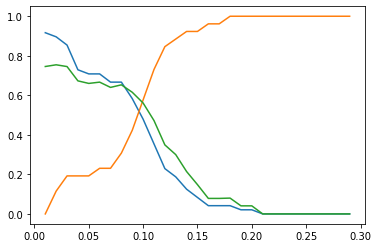

In [134]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt

sensitivities = []
specificities = []
f1s = []
aucs = []
accuracies = []

cutoffs = np.arange(0.01, 0.3, 0.01)
for cutoff in cutoffs:

    labeled_data['predict'] = labeled_data['sm_sim'] > cutoff
    labeled_data['predict'] = labeled_data['predict'].astype(int)

    cm1 = confusion_matrix(labeled_data['label'], labeled_data['predict'])
    total1=sum(sum(cm1))

    ### from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    accuracies.append(accuracy1)
    
    # true positives
    sensitivity1 = cm1[0,0]/(cm1[0,0] + cm1[0,1])
    sensitivities.append(sensitivity1)

    # true negatives
    specificity1 = cm1[1,1]/(cm1[1,0] + cm1[1,1])
    specificities.append(specificity1)

    auc = roc_auc_score(labeled_data['label'], labeled_data['predict'])
    aucs.append(auc)

    f1s.append(f1_score(labeled_data['label'], labeled_data['predict']))
    
plt.plot(cutoffs, specificities)
plt.plot(cutoffs, sensitivities)
plt.plot(cutoffs, f1s)
plt.show()

In [135]:
print(np.max(f1s))
maxpos = np.argmax(f1s)
cutoffs[maxpos]

0.7543859649122807


0.02

In [136]:
labeled_data['predict'] = (labeled_data['sm_sim'] > 0.1)

In [137]:
labeled_data.loc[labeled_data['predict']]['label'].value_counts()

1    23
0    11
Name: label, dtype: int64

In [138]:
labeled_data['predict'].value_counts()

False    40
True     34
Name: predict, dtype: int64

In [139]:
labeled_data['label'].value_counts()

1    48
0    26
Name: label, dtype: int64

In [140]:
labeled_data.drop_duplicates(['news_id', 'title']).loc[labeled_data['predict']]

,news_id,wiki_id,date,news,entity,title,wiki,label,sm_sim,predict
3,1,3,May-29-2021,philadelphia 76ers vs washington wizards - ful...,Washington Wizards - Full Game 3 Highlights (o...,Washington Wizards,washington wizards american professional baske...,1,0.123566,True
5,3,5,May-29-2021,bodycam footage released stanislaus deputy sho...,Stanislaus (organization),"California State University, Stanislaus","california state university, stanislaus (stani...",0,0.159059,True
6,3,6,May-29-2021,bodycam footage released stanislaus deputy sho...,Xander Mann,Xander Berkeley,"alexander harper ""xander"" berkeley (born decem...",0,0.174397,True
7,4,7,May-29-2021,"b.j. thomas, grammy-winning singer 'raindrops ...",B.J. Thomas,B. J. Thomas,"billy joe thomas (august 7, 1942 – may 29, 202...",1,0.135563,True
8,4,8,May-29-2021,"b.j. thomas, grammy-winning singer 'raindrops ...",Grammy,Grammy Awards,"grammy award (stylized grammy, originally call...",1,0.110533,True
9,4,9,May-29-2021,"b.j. thomas, grammy-winning singer 'raindrops ...",Raindrops Keep Fallin' (organization),Burt Bacharach,burt freeman bacharach ( bak-ə-rak; born may 1...,0,0.116471,True
10,4,10,May-29-2021,"b.j. thomas, grammy-winning singer 'raindrops ...",My Head,My Head & My Heart,"""my head & heart"" song american singer ava max...",0,0.134868,True
11,4,11,May-29-2021,"b.j. thomas, grammy-winning singer 'raindrops ...",the Grammy Hall of Fame,Grammy Hall of Fame,grammy hall fame hall fame honor musical recor...,1,0.119741,True
13,5,13,May-29-2021,trail blazers’ jusuf nurkic choice words kendr...,Trail Blazers (organization),Portland Trail Blazers,portland trail blazers (colloquially known bla...,1,0.101695,True
18,7,18,May-29-2021,best buy memorial day 2021 sale: discounts tvs...,the Amazon Echo Auto (organization),Amazon (company),"amazon.com, inc. ( am-ə-zon) american multinat...",0,0.121212,True
